![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 2, Session 2A

## Session 2A: MMCLAB Training

# <font color='orange'> **Introduction**

MMC, or mesh-based Monte Carlo, is a version of our Monte Carlo solvers which uses tetrahedrons to describe the geometry of different optically-relevant domains.

A key feature of the solver is its improved accuracy and efficiency in modelling curved surfaces.

Please run the following sections to install MMC and other needed libraries.


---
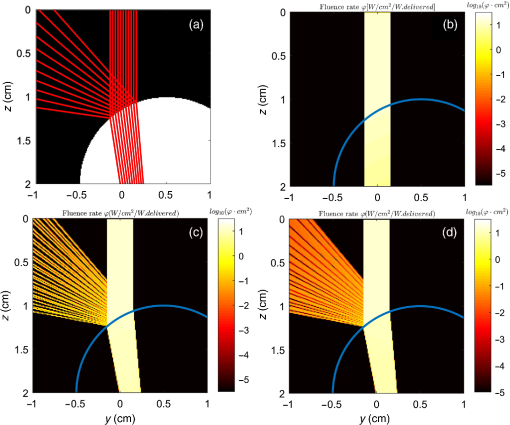
---
Above panel A, fresnel's law solved with analytical solution, panel B, solved using surface normals of voxelized sphere, panel C, solved using surface normals of mesh-based sphere, panel D, solved using interpolation of panel C result.

[Tran, Anh Phong, and Steven L. Jacques. “Modeling Voxel-Based Monte Carlo Light Transport with Curved and Oblique Boundary Surfaces.” Journal of Biomedical Optics 25, no. 2 (February 2020): 025001.](https://doi.org/10.1117/1.JBO.25.2.025001)

In [1]:
#@title Init 1: Initial setup of environment for running MMCLAB (run the below section once)</font>

# hide logs since they take up lots of screen space during installation
%%capture
# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd    # install octave (a free matlab clone)
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

!apt-get install nvidia-opencl-icd-384        # optional: install nvidia OpenCL(+2min), needed for mmc/mmclab demos
!apt-get install liboctave-dev # liboctave needed to install mmclab octave

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
! rm -rf mcxlab*
#! wget http://mcx.space/nightly/release/v2020/mmclab-linux-x86_64-v2020.zip  # download MCX suite
#! unzip -o mmclab-linux-x86_64-v2020.zip && rm -rf mmclab-linux-x86_64-v2020.zip # unzip MCX suite

# download and install MMC
!git clone https://github.com/fangq/mmc.git

# compile MMC for octave
!make oct -C mmc/src

# add executable to the shell's paths
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcx/bin/mcx /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mmc/bin/mmc /usr/local/bin
! cp -a $PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex $PWD/MCXStudio/MATLAB/zmat/

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && sudo mv /usr/local/bin/mcxcl /usr/local/bin/mcx
! mcx -L

In [2]:
# @title Init 2: Install iso2mesh for tetrahedral meshing in octave:
%%capture
# download and unzip iso2mesh
!git clone https://github.com/fangq/iso2mesh.git

In [3]:
# @title Init 3: Add paths in octave (same as adding folders in matlab)
%%octave
addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath(genpath([pwd filesep 'mmclab']));
addpath(genpath([pwd filesep 'iso2mesh']));                 % add path to iso2mesh

In [4]:
# @title Init 4: Check installation of different packages in octave
%%octave
% check that mmclab is installed
help mmclab
% check that iso2mesh is installed
help dist2surf

disp("**********************Libraries are Running as Intended*************************")

'mmclab' is a function from the file /content/mmc/mmclab/mmclab.m

 #############################################################################%

                     Mesh-based Monte Carlo (MMC) - OpenCL                   %

          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          %

              https://mcx.space/#mmc  &  https://neurojson.io/               %

                                                                             %

 Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]%

   Department of Bioengineering, Northeastern University, Boston, MA, USA    %

 #############################################################################%

    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      %

 #############################################################################%

  Open-source codes and reusable scientific data are essential for research, %

 MCX proudly developed human-readable JSON-based data formats for easy reuse.%

                                                                             %

 Please visit our free scientific data sharing portal at https://neurojson.io/%

 and consider sharing your public datasets in standardized JSON/JData format %

 #############################################################################%

 $Rev::      $v2024.2$Date::                       $ by $Author::Qianqian Fang%

 #############################################################################%

 Format:

    [fluence,detphoton,ncfg,seeds,traj]=mmclab(cfg);

          or

    fluence=mmclab(cfg);

    newcfg=mmclab(cfg,'prep');

    [fluence,detphoton,ncfg,seeds,traj]=mmclab(cfg, options);

 Input:

    cfg: a struct, or struct array. Each element in cfg defines

         a set of parameters for a simulation.

    option: (optional), options is a string, specifying additional options

         option='preview': this plots the domain configuration using mcxpreview(cfg)

         option='opencl':  force using OpenCL (set cfg.gpuid=1 if not set)

                           instead of SSE on CPUs/GPUs that support OpenCL

    cfg may contain the following fields:

 == Required ==

     *cfg.nphoton:     the total number of photons to be simulated (integer)

     *cfg.prop:        an N by 4 array, each row specifies [mua, mus, g, n] in order.

                       the first row corresponds to medium type 0 which is

                       typically [0 0 1 1]. The second row is type 1, and so on.

     *cfg.node:        node array for the input tetrahedral mesh, 3 columns: (x,y,z)

     *cfg.elem:        element array for the input tetrahedral mesh, 4 columns

     *cfg.elemprop:    element property index for input tetrahedral mesh

     *cfg.tstart:      starting time of the simulation (in seconds)

     *cfg.tstep:       time-gate width of the simulation (in seconds)

     *cfg.tend:        ending time of the simulation (in second)

     *cfg.srcpos:      a 1 by 3 vector, the position of the source in mesh node length unit

     *cfg.srcdir:      if defined as [vx, vy, vy], it specifies the incident vector

                       if defined as [vx, vy, vy, focus], the first 3 elements define

                       the incident vector; focus controls the convergence or

                       divergence of the beam:

                       focus=0: collimated beam

                       focus<0: diverging beam from an imaginary src at c0-|focus|*[vx vy vz]

                       focus>0: converging beam, focusing to a point at c0+|focus|*[vx vy vz]

                       where c0 is the centroid of the source domain. Setting focus does

                       not impact pencil/isotropic/cone sources.

 == MC simulation settings ==

      cfg.seed:        seed for the random number generator (integer)

                       if set to a uint8 array, the binary data in each column is used

                       to seed a photon (i.e. the "replay" mode), default value: 1648335518

      cfg.isreflect:   [1]-consider refractive index mismatch, 0-matched index

                       2 - total absorption on exterior surface

                       3 - prefect reflection (mirror) on exterior surface

      cfg.isnormalized:[1]-normalize the output fluence to unitary source, 0-no reflection

      cfg.isspecular:  [1]-calculate specular reflection if source is outside

      cfg.ismomentum:  [0]-save momentum transfer for each detected photon

      cfg.method:      ray-tracing method, ["plucker"]:Plucker, "havel": Havel (SSE4),

                       "badouel": partial Badouel, "elem": branchless Badouel (SSE),

                       "grid": dual-grid MMC

      cfg.mcmethod:    0 use MCX-styled MC method, 1 use MCML style MC

      cfg.nout:        [1.0] refractive index for medium type 0 (background)

      cfg.minenergy:   terminate photon when weight less than this level (float) [0.0]

      cfg.roulettesize:[10] size of Russian roulette

      cfg.steps:       [dx, dy, dz], defines the DMMC grid voxel size,

                       must be isostropic, i.e. dx=dy=dz, only used when

                       cfg.method = 'grid', by default dx=dy=dz=1

      cfg.unitinmm:    defines the default length unit (to interpret mesh nodes, src/det positions

                       the default value is 1.0 (mm). For example, if the mesh node length unit is

                       in cm, one should set unitinmm to 10.

      cfg.basisorder:  [1]-linear basis, 0-piece-wise constant basis

 == Source-detector parameters ==

      cfg.detpos:      an N by 4 array, each row specifying a detector: [x,y,z,radius]

      cfg.maxdetphoton:   maximum number of photons saved by the detectors [1000000]

      cfg.srctype:     source type, the parameters of the src are specified by cfg.srcparam{1,2}

                      'pencil' - default, pencil beam, no param needed

                      'isotropic' - isotropic source, no param needed

                      'cone' - uniform cone beam, srcparam1(1) is the half-angle in radian

                      'gaussian' - a gaussian beam, srcparam1(1) specifies the waist radius

                                (in default length unit); if one specifies a non-zero focal length

                                using cfg.srcdir, the gaussian beam can be converging to or

                                diverging from the waist center, which is located at srcpos+focus*srcdir;

                                optionally, one can specify the wavelength lambda (in cfg.unitinmm mm),

                                using srcparam1(2). This will rescale the Gaussian profile according

                                to w(z)=w0*sqrt(1-(z/z0)^2), where w0 is the waist radius, z is the

                                distance (in mm) to the waist center (focus), and z0 is the Rayleigh

                                range (in mm), and z0 is related to w0 by z0=w0^2*pi/lambda

                      'planar' - a 3D quadrilateral uniform planar source, with three corners specified

                                by srcpos, srcpos+srcparam1(1:3) and srcpos+srcparam2(1:3)

                      'pattern' - a 3D quadrilateral pattern illumination, same as above, except

                                srcparam1(4) and srcparam2(4) specify the pattern array x/y dimensions,

                                and srcpattern is a floating-point pattern array, with values between [0-1].

                                if cfg.srcnum>1, srcpattern must be a floating-point array with

                                a dimension of [srcnum srcparam1(4) srcparam2(4)]

                                Example: <demo_photon_sharing.m>

                      'fourier' - spatial frequency domain source, similar to 'planar', except

                                the integer parts of srcparam1(4) and srcparam2(4) represent

                                the x/y frequencies; the fraction part of srcparam1(4) multiplies

                                2*pi represents the phase shift (phi0); 1.0 minus the fraction part of

                                srcparam2(4) is the modulation depth (M). Put in equations:

                                    S=0.5*[1+M*cos(2*pi*(fx*x+fy*y)+phi0)], (0<=x,y,M<=1)

                      'arcsine' - similar to isotropic, except the zenith angle is uniform

                                distribution, rather than a sine distribution.

                      'disk' - a uniform disk source pointing along srcdir; the radius is

                               set by srcparam1(1) (in default length unit)

                      'fourierx' - a general Fourier source, the parameters are

                               srcparam1: [v1x,v1y,v1z,|v2|], srcparam2: [kx,ky,phi0,M]

                               normalized vectors satisfy: srcdir cross v1=v2

                               the phase shift is phi0*2*pi

                      'fourierx2d' - a general 2D Fourier basis, parameters

                               srcparam1: [v1x,v1y,v1z,|v2|], srcparam2: [kx,ky,phix,phiy]

                               the phase shift is phi{x,y}*2*pi

                      'zgaussian' - an angular gaussian beam, srcparam1(1) specifies the variance in

                               the zenith angle

      cfg.{srcparam1,srcparam2}: 1x4 vectors, see cfg.srctype for details

      cfg.srcpattern: see cfg.srctype for details

      cfg.srcnum:     the number of source patterns that are

                      simultaneously simulated; only works for 'pattern'

                      source, see cfg.srctype='pattern' for details

                      Example <demo_photon_sharing.m>

      cfg.replaydet:  only works when cfg.outputtype is 'jacobian', 'wl', 'nscat', or 'wp' and cfg.seed is an array

                       0 replay all detectors and sum all Jacobians into one volume

                       a positive number: the index of the detector to replay and obtain Jacobians

      cfg.voidtime:   for wide-field sources, [1]-start timer at launch, 0-when entering

                      the first non-zero voxel

      by default, mmc assumes the mesh and source position settings are all in mm unit.

      if the mesh coordinates/source positions are not in mm unit, one needs to define

      cfg.unitinmm  (in mm) to specify the actual length unit.

 == Optional mesh data ==

     -cfg.facenb:      element face neighbohood list (calculated by faceneighbors())

     -cfg.evol:        element volume (calculated by elemvolume() with iso2mesh)

     -cfg.e0:          the element ID enclosing the source, if not defined,

                       it will be calculated by tsearchn(node,elem,srcpos);

                       if cfg.e0 is set as one of the following characters,

                       mmclab will do an initial ray-tracing and move

                       srcpos to the first intersection to the surface:

                       '>': search along the forward (srcdir) direction

                       '<': search along the backward direction

                       '-': search both directions

 == Output control ==

      cfg.issaveexit: [0]-save the position (x,y,z) and (vx,vy,vz) for a detected photon

      cfg.issaveref:  [0]-save diffuse reflectance/transmittance on the exterior surfaces.

                      The output is stored as flux.dref in a 2D array of size [#Nf,  #time_gate]

                      where #Nf is the number of triangles on the surface; #time_gate is the

                      number of total time gates. To plot the surface diffuse reflectance, the output

                      triangle surface mesh can be extracted by faces=faceneighbors(cfg.elem,'rowmajor');

                      where 'faceneighbors' can be found in the iso2mesh toolbox.

                      Example: see <demo_mmclab_basic.m>

      cfg.issaveseed:  [0]-save the RNG seed for a detected photon so one can replay

      cfg.isatomic:    [1]-use atomic operations for saving fluence, 0-no atomic operations

      cfg.outputtype:  'flux' - output fluence-rate

                       'fluence' - fluence,

                       'energy' - energy deposit,

                       'jacobian' - mua Jacobian (replay mode)

                       'wl'- weighted path lengths to build mua Jacobian (replay mode)

                       'wp'- weighted scattering counts to build mus Jacobian (replay mode)

      cfg.debuglevel:  debug flag string, a subset of [SCBWDIOXATRPEM], no space

      cfg.debugphoton: print the photon movement debug info only for a specified photon ID

      cfg.maxjumpdebug: [10000000|int] when trajectory is requested in the output,

                     use this parameter to set the maximum position stored. By default,

                     only the first 1e6 positions are stored.

      fields marked with * are required; options in [] are the default values

      fields marked with - are calculated if not given (can be faster if precomputed)

    type: omit or 'omp' for multi-threading version; 'sse' for the SSE4 MMC,

          the SSE4 version is about 25% faster, but requires newer CPUs;

          if type='prep' with a single output, mmclab returns ncfg only.

 Output:

      fluence: a struct array, with a length equals to that of cfg.

            For each element of fluence, fluence(i).data is a 2D array with

            dimensions [size(cfg.node,1), total-time-gates] if cfg.basisorder=1,

            or [size(cfg.elem,1), total-time-gates] if cfg.basisorder=0.

            The content of the array is the normalized fluence-rate (or others

            depending on cfg.outputtype) at each mesh node and time-gate.

            If cfg.issaveref is set to 1, fluence(i).dref is not empty, and stores

            the surface diffuse reflectance (normalized by default). The surface mesh

            that the dref output is attached can be obtained by faces=faceneighbors(cfg.elem,'rowmajor');

      detphoton: (optional) a struct array, with a length equals to that of cfg.

            Starting from v2016.5, the detphoton contains the below subfields:

              detphoton.detid: the ID(>0) of the detector that captures the photon

              detphoton.nscat: cummulative scattering event counts in each medium

              detphoton.ppath: cummulative path lengths in each medium (partial pathlength)

                   one need to multiply cfg.unitinmm with ppath to convert it to mm.

              detphoton.mom: cummulative cos_theta for momentum transfer in each medium

              detphoton.p or .v: exit position and direction, when cfg.issaveexit=1

              detphoton.w0: photon initial weight at launch time

              detphoton.prop: optical properties, a copy of cfg.prop

              detphoton.data: a concatenated and transposed array in the order of

                    [detid nscat ppath mom p v w0]'

              "data" is the is the only subfield in all MMCLAB before 2016.5

      ncfg: (optional), if given, mmclab returns the preprocessed cfg structure,

            including the calculated subfields (marked by "-"). This can be

            used in the subsequent simulations to avoid repetitive preprocessing.

      seeds: (optional), if give, mmclab returns the seeds, in the form of

            a byte array (uint8) for each detected photon. The column number

            of seed equals that of detphoton.

      trajectory: (optional), if given, mmclab returns the trajectory data for

            each simulated photon. The output has 6 rows, the meanings are

               id:  1:    index of the photon packet

               pos: 2-4:  x/y/z/ of each trajectory position

                    5:    current photon packet weight

                    6:    enclosing element's ID

            By default, mcxlab only records the first 1e7 positions along all

            simulated photons; change cfg.maxjumpdebug to define a different limit.

 Example:

      cfg.nphoton=1e5;

      [cfg.node face cfg.elem]=meshabox([0 0 0],[60 60 30],6);

      cfg.elemprop=ones(size(cfg.elem,1),1);

      cfg.srcpos=[30 30 0];

      cfg.srcdir=[0 0 1];

      cfg.prop=[0 0 1 1;0.005 1 0 1.37];

      cfg.tstart=0;

      cfg.tend=5e-9;

      cfg.tstep=5e-10;

      cfg.debuglevel='TP';

      % preprocessing to populate the missing fields to save computation

      ncfg=mmclab(cfg,'prep');

      cfgs(1)=ncfg;   % when using struct array input, all fields must be defined

      cfgs(2)=ncfg;

      cfgs(1).isreflect=0;

      cfgs(2).isreflect=1;

      cfgs(2).detpos=[30 20 0 1;30 40 0 1;20 30 1 1;40 30 0 1];

      % calculate the fluence and partial path lengths for the two configurations

      [fluxs,detps]=mmclab(cfgs);

 This function is part of Mesh-based Monte Carlo (MMC) URL: http://mcx.space/#mmc

 License: GNU General Public License version 3, please read LICENSE.txt for details

Additional help for built-in functions and operators is

available in the online version of the manual.  Use the command

'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW

at https://www.octave.org and via the help@octave.org

mailing list.

'dist2surf' is a function from the file /content/iso2mesh/dist2surf.m

  [d2surf,cn]=dist2surf(node,nv,p)

  calculate the distances from a point cloud to a surface, and return

  the indices of the closest surface node

  author: Qianqian Fang <q.fang at neu.edu>

  date: 12/12/2008

 parameters:

      node: node coordinate of the surface mesh (nn x 3)

      nv: nodal norms (vector) calculated from nodesurfnorm.m

          with dimensions of (size(node,1),3), this can be

          calcuated from nodesurfnorm.m

      pt: points to be calculated, 3 columns for x,y and z respectively

 outputs:

      d2surf: a vector of length of p, the distances from p(i) to the surface

      cn: a integer vector with the length of p, the indices of the closest surface node

 Please find more information at http://iso2mesh.sf.net/cgi-bin/index.cgi?metch

 this function is part of "metch" toobox, see COPYING for license

Additional help for built-in functions and operators is

available in the online version of the manual.  Use the command

'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW

at https://www.octave.org and via the help@octave.org

mailing list.

**********************Libraries are Running as Intended*************************

#  <font color='orange'> **Forward simulation in a layered slab**

## **Key objectives of the section:**

*   Meshing of simple layered domain
*   Key MMC inputs
*   Plotting MMC fluence and flux
*   MMC advantages and limitations





## Mesh introduction/refresher

###**What is a mesh?**
A mesh is a set of points in 3D space (**nodes**) and a series of relationships that attach them to one another.

- In MMC, the smallest units of our meshes are **tetrahedrons**, which we call **elements (elem)**.
    - Each tetrahedron elem has four **nodes**, one for each corner

- We can also describe a mesh using just its boundary surfaces, this is called a surface mesh.
    - surface meshes use triangular **faces** instead of tetrahedron
    
    ---
Above: left - a hemisphere solid mesh, right - a hemisphere surface mesh

To create and modify meshes, we use the iso2mesh library.

Several basic functions can be used to create an initial tetrahedral mesh, including:

- meshgrid5
- meshgrid6
- meshabox
- latticegrid
- meshasphere
- meshacyl

Documentation of the library can be found here: https://iso2mesh.sourceforge.net/cgi-bin/index.cgi/.




## **Explaining mesh variables**:

A solid mesh can be created with two matrix variables:

 - The **node** variable stores all the coordinates of the points in the mesh
    - it is always a three column matrix

 - The **elem** variable stores the index of all the nodes making up a tetrahedron in each row.
    - it is usually a 4 column matrix (another column may be used to track materials)

---
One of the simplest meshes you can create is a cube or rectangular prism using the **meshgrid6** function. This function slices a rectangular prism into 6 equally sized tetrahedrons.

The code below shows a a mesh created with this function and the variables that describe it.


The node values are:

     0     0     0

   110     0     0

     0    70     0

   110    70     0

     0     0    80

   110     0    80

     0    70    80

   110    70    80

Each row displays the coordinates of a node

-----------------------------------------------------------

The element values are:

   1   2   8   4

   1   3   4   8

   1   2   6   8

   1   5   8   6

   1   3   8   7

   1   5   7   8

Each row displays the four IDs of nodes making up a tetrahedron

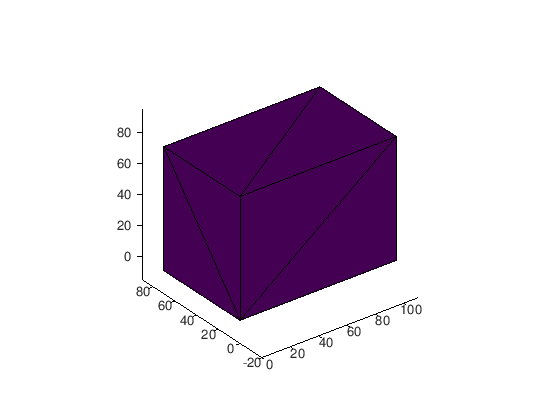

In [ ]:
#@title **Creating a simple lattice**
%%octave

x_coordinates = [0, 110];
y_coordinates = [0, 70];
z_coordinates = [0, 80];
[node, elem] = meshgrid6(x_coordinates, y_coordinates, z_coordinates);
figure;
caxis([0,10000]);
plotmesh(node, elem);

disp('The node values are:')
disp(node);
disp('Each row displays the coordinates of a node')
disp('-----------------------------------------------------------')
disp('The element values are:')
disp(elem);
disp('Each row displays the four IDs of nodes making up a tetrahedron')

We can add a column to elements for optical properties:

Below, each tetrahedron is given its own material ID

------------------------------------------------------------

The element values are:

   1   2   8   4   1

   1   3   4   8   2

   1   2   6   8   3

   1   5   8   6   4

   1   3   8   7   5

   1   5   7   8   6

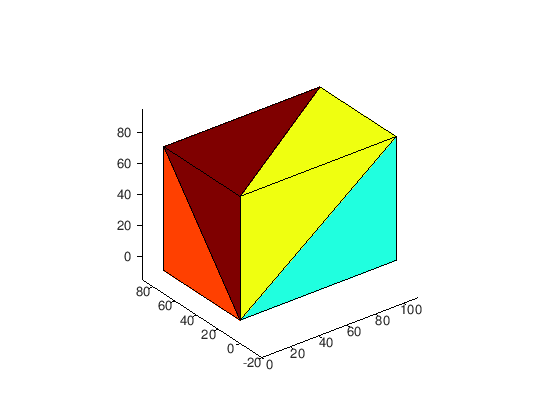

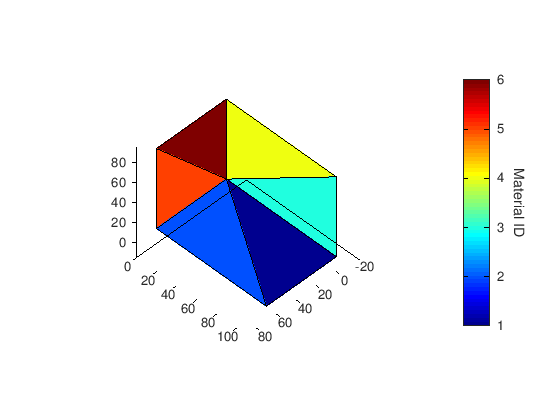

In [ ]:
#@title **Setting properties of a simple lattice**
%%octave
disp('We can add a column to elements for optical properties:')
disp('Below, each tetrahedron is given its own material ID')
disp('------------------------------------------------------------')
disp('The element values are:')
elem_with_mat = [elem, [1:size(elem,1)]'];
disp(elem_with_mat);

figure;
plotmesh(node, elem_with_mat);
colormap('jet');
figure;
plotmesh(node, elem_with_mat);
view(-45,-45)

cb = colorbar;
colormap('jet');
ylabel(cb,'Material ID','FontSize',30,'Rotation',270);

##**Creating a 5-layered slab**

The meshgrid6 function is useful but as we can see, it does not allow us to create **multiple property-labelled regions** easily.

The **latticegrid** function allows us to create a **multi-layered slab** in two steps:




1. Specify dimensions for surface mesh

In [ ]:
%%octave

% thickness of each layer in mm
Thickness=[7.25,4.00,2.73,3.29,4.23];

% prepare simulation mesh (a five layered slab of 50mm x 50mm x 50mm):
% prepares a surface-only mesh:
x_bounds = [0 50];
y_bounds = [0 50];
z_layer_heights = [0 Thickness(1,1) sum(Thickness(1,1:2)) sum(Thickness(1,1:3)) sum(Thickness(1,1:4)) 50];
[nodes,faces]=latticegrid(x_bounds, y_bounds, z_layer_heights);


2. Convert the surface mesh to a solid mesh

In [ ]:
%%capture
%%octave
% prepares interior tetrahedrons for that mesh:
% max_volume is very important and determines our mesh density
% dramatically impacts performance:
max_volume = 1000;

[nodes,elems]=surf2mesh(nodes,faces,[],[],1,max_volume,[1 1 4;1 1 9;1 1 12;1 1 14.5;1 1 25]);


Display key info and plot the mesh:

Size of the node matrix (rows) (columns):

   1050      3

Size of the element matrix (rows) (columns):

   5198      5

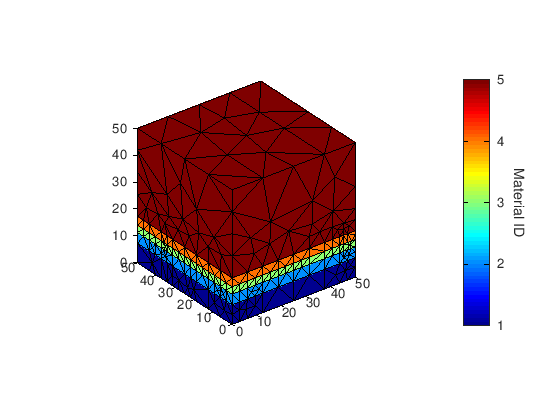

In [ ]:
%%octave
% display the size of the mesh
disp('Size of the node matrix (rows) (columns):');
disp(size(nodes));
disp('Size of the element matrix (rows) (columns):');
disp(size(elems));

% plot the tetrahedral mesh to verify it is correct:
plotmesh(nodes, elems);
cb = colorbar;
colormap('jet');
ylabel(cb,'Material ID','FontSize',30,'Rotation',270);


## Preparing MMC inputs

For the MMC simulation, we have to create a config struct.
This struct can be named anything and will contain a series of settings and simulation parameters as fields.

The bare essential fields are:
- a mesh with nodes and elements
- a list of properties for all element IDs
- a source position and direction
- Time gates and steps (in seconds)
- number of photons

Delete any existing config variable:

In [ ]:
%%octave
clear cfg_mmc

Set the mesh for the simulation:

In [ ]:
%%octave
% set the config values to the mesh variables
cfg_mmc.node=nodes;
cfg_mmc.elem=elems;


Set the medium properties for background (air) and all 5 layers

In [ ]:
%%octave
% set the medium properties:
% labeling, row 1-air,2-scalp,3-skull,4-csf,5-gray matter,6-white matter
cfg_mmc.prop=[0,0,1,1;
              0.019, 7.8, 0.95, 1.37;
              0.019, 7.8, 0.95, 1.37;
              0.004, 0.009, 0.95, 1.37;
              0.02, 9.0, 0.95, 1.37;
              0.08, 40.9, 0.95, 1.37];


Set the number of photons:
(More = slower but less noisy results)

In [ ]:
%%octave
% set the number of photons
number_of_photons=100000 # @param {type:"slider", min:0, max:100000, step:100}
cfg_mmc.nphoton=number_of_photons;

number_of_photons = 100000

Set the source position and direction:

In [ ]:
%%octave
% set the source position and direction:
cfg_mmc.srcpos=[25, 25, 0];
cfg_mmc.srcdir=[0, 0, 1];


Set the time gates and time steps:

In [ ]:
%%octave
% set the time bounds of the simulation in seconds:
cfg_mmc.tstart=0;
cfg_mmc.tend=5e-9;
cfg_mmc.tstep=5e-9;

% while we're at it, set the output to fluence,
% which is flux integrated by the time step
cfg_mmc.outputtype='fluence';

Choose a method for storing fluence:

In [ ]:
%%octave
MMC_method = "grid" # @param ["elem", "grid"]
cfg_mmc.method = MMC_method;

MMC_method = grid

In [ ]:
%%octave
%Set the MMC random seed
seed = 2433243 # @param
cfg_mmc.seed = seed;

seed = 2433243

##Run MMC simulation

Quick final plot of our source and domain to make sure it's set up right

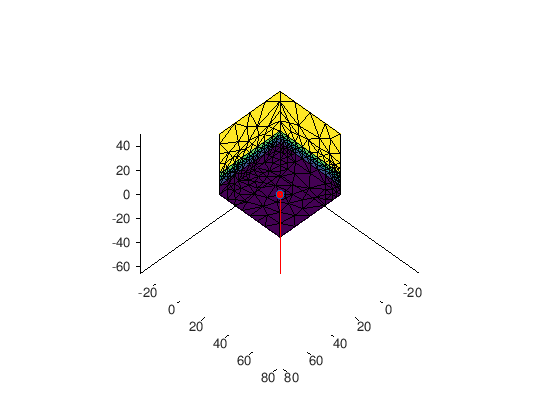

In [ ]:
%%octave
% we can plot the source position and direction
% to verify it is in the location on the mesh:
figure;
hold on;
plotmesh(nodes, elems);
scatter3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3), 500, 'MarkerFaceColor', 'r');
quiver3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3),
        cfg_mmc.srcdir(1), cfg_mmc.srcdir(2), cfg_mmc.srcdir(3), 'MaxHeadSize', 44, 'Color', 'r', 'MarkerFaceColor', 'r');
view(-45,-45)

Run the simulation

In [ ]:
%%octave

% this sets up a progress bar and timer
cfg_mmc.debuglevel='TP';

% picks which gpu to run on, by setting ones or zeros.
% if you had three GPUs and you wanted to use all three, you would do:
% cfg_mmc.gpuid='111';
% if you had three GPUs and wanted to use the last two, you would do:
% cfg_mmc.gpuid='011';

cfg_mmc.gpuid='1';

fluence = mmclab(cfg_mmc);

## MMC outputs and plotting

MMC has two output types for fluence,


1.   Element based (fluence values are stored for each node)
2.   Grid based (fluence values are stored in a 3d grid even though they are calculated using a mesh)

Grid based simulations tend to be more efficient, but they may lack precision if you are interested in fine features on surfaces (by default the grid is made of 1mm^3 cubes)


Create a 2D set of coordinates for plotting:

In [ ]:
%%octave
% distance along the x-axis for the plane containing
% source and detectors
cross_section_srcdist = 25;

% define a plane using cross section srcplane:
cutting_plane = [cross_section_srcdist 0 0;cross_section_srcdist 1 0;cross_section_srcdist 0 1];

% vector of y-coorinates for the cross section
% note that our slab is 50mm wide
% if we want to plot fluence values at the center of each 1mm cube,
% we would start at 0.5 and go to 49.5 with 50 steps
cubesize = 1; % cube of 1mm x 1mm x 1mm

y_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% vector of z-coordinates for the cross section
% same as y-coordinates but the height of the slab is 50mm
z_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% make a grid of coordinates for all fluence values in the cross section
[yy,zz]=meshgrid(y_vals,z_vals);

Obtain fluence values for a crosssection of the mesh, interpolate them to the grid

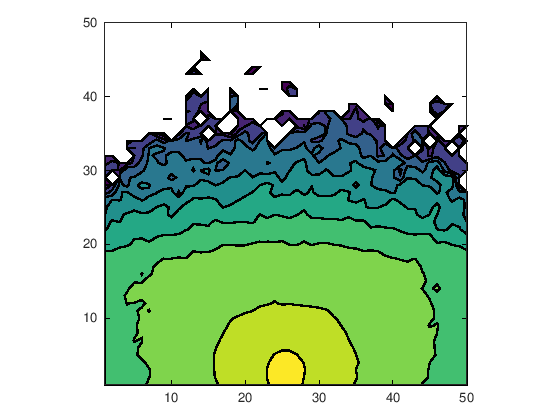

In [ ]:
%%octave
if(strcmp(cfg_mmc.method, 'elem'))
    % qmeshcut gets the intersections of all mesh edges and a plane
    % as a set of coordinate points and a set of interpolated values
    [cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data,cutting_plane);

    plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);
end

if(strcmp(cfg_mmc.method, 'grid'))
    % plot a slice of the output grid nearest to the source plane
    % squeeze gets rid of a one-value dimension to the matrix
        plottable_fluence_data = squeeze(fluence.data(25, 1:50, 1:50));
        plottable_fluence_data = rot90(plottable_fluence_data, -1);
end

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
[yy_plot,zz_plot]=meshgrid(1:(50),1:(50));
contourf(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),'linewidth',5,'linestyle','-','DisplayName','Diffusion');
axis equal;
title('Fluence of a 5-layered slab')



**Why use MMC over MCX?**

As we saw in this section, MMC can be used to define and simulate layers with intermediate thicknesses with differences on the order of hundredths of a milimeter.

In the next section we will use MMC to simulate light travelling through a head model with curved boundaries.

#<font color='orange'>**Forward simulation in a brain atlas**

## **Key objectives of the section:**

*   Loading a pre-made mesh
*   Plotting time-resolved fluence
*   Using detected photons and partial paths

Clear all previously created variables

In [5]:
%%octave
clear;

Load the atlas mesh

In [6]:
%%octave
load('mmc/mmclab/example/head_atlas.mat');
node = double(node);
elem = double(elem);
prop = double(prop);

In [20]:
%%octave
%% prepare cfg for MMCLAB simulation
clear cfg
cfg.nphoton=1e5; %takes ~240s on Intel i7-8700K(12 threads)

% medium labels:0-ambient air,1-air cavities,2-scalp,3-skull,4-csf,5-gray matter,6-white matter
cfg.node=node;
cfg.elem=elem;
cfg.elemprop=prop;
cfg.prop=[0,0,1,1;0,0,1,1;0.019 7.8 0.89 1.37;0.019 7.8 0.89 1.37;0.004 0.009 0.89 1.37;0.02 9.0 0.89 1.37;0.08 40.9 0.84 1.37];

% light source
cfg.srctype='pencil';
cfg.srcdir=[-0.5086,-0.1822,-0.8415]; %inward-pointing source
cfg.srcpos=[133.5370,90.1988,200.0700]; %pencil beam source placed at EEG 10-5 landmark:"C4h"
    cfg.srcpos=cfg.srcpos+0.001*cfg.srcdir; %ensure source is inside the mesh

cfg.detpos = [140, 90.5, 194, 1.5;
              150, 90.5, 182, 1.5]; % detector position

% time windows
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-10;

% other simulation parameters
cfg.isreflect=1;
cfg.debuglevel='TP';
cfg.method='grid'; %DMMC mode

%% run mmc simulation
[flux, detected_photons]=mmclab(cfg);

Launching MMCLAB - Mesh-based Monte Carlo for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mmc.nphoton=100000;

mmc.nn=59225;

mmc.elem=[335713,4];

mmc.ne=335713;

mmc.prop=6;

mmc.srctype='pencil';

mmc.srcdir=[-0.5086 -0.1822 -0.8415 0];

mmc.srcpos=[133.536 90.1986 200.069];

mmc.detnum=2;

mmc.tstart=0;

mmc.tend=5e-09;

mmc.tstep=5e-10;

mmc.isreflect=1;

mmc.debuglevel='TP';

mmc.method='grid';

mmc.facenb=[335713,4];

mmc.evol=335713;

mmc.e0=272785;

	done	69

simulating ...

###############################################################################

#                     Mesh-based Monte Carlo (MMC) - OpenCL                   #

#          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          #

#              https://mcx.space/#mmc  &  https://neurojson.io/               #

#                                                                             #

#Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]#

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::      $v2024.2 $Date::                       $ by $Author::             $

###############################################################################

- variant name: [MMC-OpenCL] compiled with OpenCL version [1]

- compiled with: [RNG] xorshift128+ RNG [Seed Length] 4

initializing streams ...	init complete : 0 ms

Building kernel with option: -cl-mad-enable -DMCX_USE_NATIVE -DMCX_SIMPLIFY_BRANCH -DMCX_VECTOR_INDEX -DMCX_SRC_PENCIL   -DUSE_ATOMIC -DMCX_SAVE_DETECTORS -DMCX_DO_REFLECTION -DUSE_DMMC

build program complete : 79 ms

- [device 0(1): pthread-Intel(R) Xeon(R) CPU @ 2.20GHz] threadph=781 oddphotons=32 np=100000.0 nthread=128 nblock=64 repetition=1

set kernel arguments complete : 79 ms 4

lauching mcx_main_loop for time window [0.0ns 5.0ns] ...

simulation run# 1 ...

Progress: [>                                                             ]   0%Progress: [=>                                                            ]   3%Progress: [==>                                                           ]   4%Progress: [===>                                                          ]   5%Progress: [====>                                                         ]   7%Progress: [=====>                                                        ]   9%Progress: [======>                                  

kernel complete:  	26734 ms

retrieving flux ... 	detected 400 photons, total: 400	transfer complete:        27082 ms

normalizing raw data ...	simulated 100000 photons (100000) with 1 devices (ray-tet 191717488)

MCX simulation speed: 3.75 photon/ms

total simulated energy: 100000.00	absorbed: 48.11409%

(loss due to initial specular reflection is excluded in the total)

	done	28917

Plot the fluence cross section:

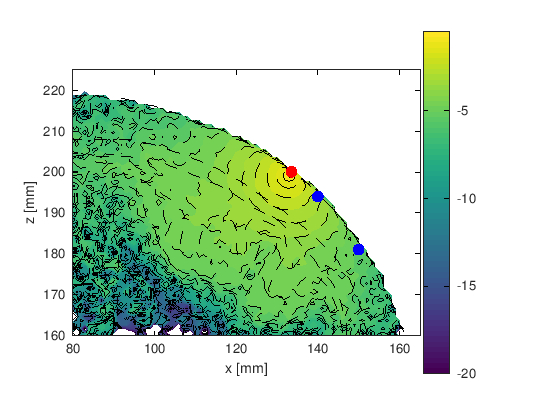

In [22]:
%%octave
%% post-simulation data processing and visualization
% convert time-resolved fluence to CW fluence
CWfluence=sum(flux.data*cfg.tstep,4);

% coronal plane selected for fluence plot
y_plane=90.5;

% fix spatial offset between the coordinate origins of DMMC AABB and the mesh
DMMC_AABB_origin=min(cfg.node); %spatial offset of the DMMC AABB
DMMC_voxel_origin=DMMC_AABB_origin+0.5; %centroid of the 1st voxel for DMMC AABB
DMMC_AABB_dimension=size(CWfluence);
CWfluence_DMMC=squeeze(CWfluence(:,ceil(y_plane-DMMC_AABB_origin(1,2)),:)); %along y-axis, DMMC AABB happens to have an offset very close to 3(2.9955)
[xx,zz]=meshgrid(DMMC_voxel_origin(1,1):(DMMC_voxel_origin(1,1)+DMMC_AABB_dimension(1,1)-1),DMMC_voxel_origin(1,3):(DMMC_voxel_origin(1,3)+DMMC_AABB_dimension(1,3)-1));

figure;
clines=-20:0.5:0;
contourf(xx,zz,log10(abs(CWfluence_DMMC')),clines,'linestyle','--','linewidth',1.5,'DisplayName','DMMC');
hold on;axis equal;
colorbar('EastOutside');

% plot tissue boundaries, auxiliary functions are part of iso2mesh(http://iso2mesh.sf.net)
plane=[0 y_plane 0; 0 y_plane 1; 1 y_plane 0];
label=unique(prop);
face=[];
for i=1:2:size(label,1)
    newface=volface(cfg.elem(prop==label(i),:));
    face=[face;newface];
end
[cutpos,cutvalue,cutedges]=qmeshcut(face(:,1:3),node,node(:,1),plane);
[cutpos,cutedges]=removedupnodes(cutpos,cutedges);
cutloop=extractloops(cutedges);
[nanidx]=find(isnan(cutloop));

for i=1:size(nanidx,2)
    if(i==9)
        continue;
    end
    if(i==1)
        plot(cutpos(cutloop(1:(nanidx(i)-1)),1),cutpos(cutloop(1:(nanidx(i)-1)),3),'linestyle','--','color','k','LineWidth',1.25,'HandleVisibility','off');
    elseif(i==2)
        plot(cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),1),cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),3),'linestyle','--','color','k','LineWidth',1.25,'HandleVisibility','off');
    else
        plot(cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),1),cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),3),'linestyle','--','color','k','LineWidth',1.25,'HandleVisibility','off');
    end
end

plot(cfg.srcpos(1,1),cfg.srcpos(1,3),'o','MarkerEdgeColor','r','MarkerFaceColor','r','MarkerSize',10,'DisplayName','source');
plot(cfg.detpos(1,1),cfg.detpos(1,3),'o','MarkerEdgeColor','b','MarkerFaceColor','b','MarkerSize',10,'DisplayName','detector');
plot(cfg.detpos(2,1),cfg.detpos(2,3),'o','MarkerEdgeColor','b','MarkerFaceColor','b','MarkerSize',10,'DisplayName','detector');
set(gca,'ylim', [160 225]);ylabel('z [mm]');
set(gca,'xlim', [80 165]);xlabel('x [mm]');

#<font color='orange'> **Simulation with a Pattern Source:**

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

refining the input mesh ...

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

mesh refinement is complete

Launching MMCLAB - Mesh-based Monte Carlo for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mmc.prop=3;

mmc.nn=22023;

mmc.elem=[132493,4];

mmc.ne=132493;

mmc.srctype='fourier';

mmc.srcpos=[10 10 35];

mmc.srcparam1=[40 0 0 3.16667];

mmc.srcparam2=[0 40 0 0];

mmc.srcdir=[0 0 -1 0];

mmc.nphoton=300;

mmc.seed=1648335518;

mmc.tstart=0;

mmc.tend=5e-09;

mmc.tstep=1e-10;

mmc.debuglevel='TP';

mmc.isreflect=1;

mmc.detnum=1;

mmc.method='elem';

mmc.facenb=[132493,4];

mmc.evol=132493;

mmc.e0=124494;

	done	66

simulating ...

###############################################################################

#                     Mesh-based Monte Carlo (MMC) - OpenCL                   #

#          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          #

#              https://mcx.space/#mmc  &  https://neurojson.io/               #

#                                                                             #

#Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]#

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::      $v2024.2 $Date::                       $ by $Author::             $

###############################################################################

- code name: [MMC-OpenCL] compiled with OpenCL version [1]

- compiled with: [RNG] xorshift128+ RNG [Seed Length] 4

initializing streams ...	init complete : 0 ms

Building kernel with option: -cl-mad-enable -DMCX_USE_NATIVE -DMCX_SIMPLIFY_BRANCH -DMCX_VECTOR_INDEX -DMCX_SRC_FOURIER   -DUSE_ATOMIC -DMCX_DO_REFLECTION -DUSE_BLBADOUEL -DUSE_NVIDIA_GPU

build program complete : 8 ms

- [device 0(1): Tesla T4] threadph=0 oddphotons=300 np=300.0 nthread=163840 nblock=64 repetition=1

set kernel arguments complete : 8 ms 3

lauching mcx_main_loop for time window [0.0ns 5.0ns] ...

simulation run# 1 ...

Progress: [>                                                             ]   0%Progress: [==================>                                           ]  29%Progress: [==============================================================] 100%

kernel complete:  	270 ms

retrieving flux ... 	transfer complete:        322 ms

normalizing raw data ...	simulated 300 photons (300) with 1 devices (ray-tet 234086)

MCX simulation speed: 1.15 photon/ms

total simulated energy: 150.03	absorbed: 44.27123%

(loss due to initial specular reflection is excluded in the total)

	done	1060

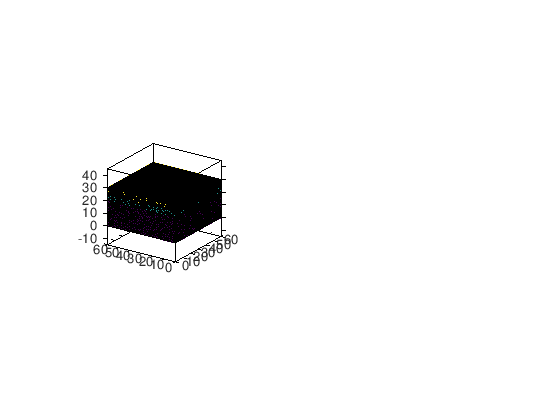

In [ ]:
%%octave

%%-----------------------------------------------------------------
%% Simulating an SFDI source with a 2-layer brain model
%%-----------------------------------------------------------------
%
% In this example, we simulate an spatial-frequency domain imaging source
% using a 2-layer brain model.
%
% The cubic domain has a dimension of 60x60x30 mm with the 5mm top layer
% simulating the skull/scalp while the bottom 25mm layer simulating gray
% and white matters. The sample SFDI covers a 40 x 40 mm area from the top,
% and has kx=3 with a pi/3 phase offset in the x-direction.
%
%%-----------------------------------------------------------------

clear cfg;
clear all;

%% 2-layer mesh model

layercount=3;

if(layercount==2)
    [node,face,c0]=latticegrid([0 60],[0 60],[0 25 30]);
    c0(:,4)=[2;1];   % maximum element size for bottom (label 1) and top (label 2) layers

    % simulate the optical properties of skull and gray-matter of a human brain model
    % see http://mcx.sourceforge.net/cgi-bin/index.cgi?MMC/Colin27AtlasMesh
    cfg.prop=[0 0 1 1;0.02 9.0, 0.89 1.37;0.019 7.8 0.89 1.37];
else
    [node,face,c0]=latticegrid([0 60],[0 60],[0 20 25 30]); % if you like a 3-layer model
    c0(:,4)=[2;2;1];
    cfg.prop=[0 0 1 1;0.02 9.0, 0.89 1.37;0.004 0.009, 0.89 1.37;0.019 7.8 0.89 1.37];
end
[cfg.node,cfg.elem]=surf2mesh(node,face,[],[],1,[],c0);

figure;
subplot(121);
plotmesh(cfg.node,cfg.elem);

cfg.elemprop=cfg.elem(:,5);
cfg.elem=cfg.elem(:,1:4);


%% add source and retessellate mesh

cfg.srctype='fourier';      % define an SFDI source
cfg.srcpos=[10 10 35];      % one corner of the illumination area
kx=3;                       % wave number in the x-dir
ky=0;                       % wave number in the x-dir
xphase=pi/3;                % phase offset in the x-dir, must < 2pi
yphase=0;                   % phase offset in the x-dir, must < 2pi
cfg.srcparam1=[40 0 0 kx+xphase/(2*pi)];   % kx is k-number in x direction
cfg.srcparam2=[0 40 0 ky+yphase/(2*pi)];
cfg.srcdir=[0 0 -1];

%% line 24-31 could possibly be deleted and replaced by built-in one-step command
srcdef=struct('srctype',cfg.srctype,'srcpos',cfg.srcpos,'srcdir',cfg.srcdir,...
    'srcparam1',cfg.srcparam1,'srcparam2',cfg.srcparam2);

[cfg.node,cfg.elem] = mmcaddsrc(cfg.node,[cfg.elem cfg.elemprop],...
    mmcsrcdomain(srcdef,[min(cfg.node);max(cfg.node)]));

cfg.elemprop=cfg.elem(:,5);
cfg.elem=cfg.elem(:,1:4);

%% other simulation information

cfg.nphoton=3e2;
cfg.seed=1648335518;

cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=1e-10;

cfg.debuglevel='TP';
cfg.isreflect=1;
cfg.detpos=[30 30 0 2]; % detector position
cfg.method='elem';

%% mmc simulation

layer=mmclab(cfg);
%cube=mmclab(cfg,'sse'); % this is faster
layer=layer.data;
layercw=sum(layer,2);

% plot simulated photon profiles

hold on;
%qmeshcut(cfg.elem(cfg.elemprop>0,1:4),cfg.node,log10(layercw),'y=30','linestyle','none'); view(3)
%qmeshcut(cfg.elem(cfg.elemprop>0,1:4),cfg.node,log10(layercw),'z=27','linestyle','none');
%if(layercount~=2)
%    qmeshcut(cfg.elem(cfg.elemprop>0,1:4),cfg.node,log10(layercw),'z=22','linestyle','none');
%end
box on;
axis equal
view(-56, 22);

In [ ]:
%%octave
help mmclab

'mmclab' is a function from the file /content/mmc/mmclab/mmclab.m

 #############################################################################%

                     Mesh-based Monte Carlo (MMC) - OpenCL                   %

          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          %

              https://mcx.space/#mmc  &  https://neurojson.io/               %

                                                                             %

 Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]%

   Department of Bioengineering, Northeastern University, Boston, MA, USA    %

 #############################################################################%

    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      %

 #############################################################################%

  Open-source codes and reusable scientific data are essential for research, %

 MCX proudly developed human-readable JSON-based data formats for easy reuse.%

                                                                             %

 Please visit our free scientific data sharing portal at https://neurojson.io/%

 and consider sharing your public datasets in standardized JSON/JData format %

 #############################################################################%

 $Rev::      $v2024.2$Date::                       $ by $Author::Qianqian Fang%

 #############################################################################%

 Format:

    [fluence,detphoton,ncfg,seeds,traj]=mmclab(cfg);

          or

    fluence=mmclab(cfg);

    newcfg=mmclab(cfg,'prep');

    [fluence,detphoton,ncfg,seeds,traj]=mmclab(cfg, options);

 Input:

    cfg: a struct, or struct array. Each element in cfg defines

         a set of parameters for a simulation.

    option: (optional), options is a string, specifying additional options

         option='preview': this plots the domain configuration using mcxpreview(cfg)

         option='opencl':  force using OpenCL (set cfg.gpuid=1 if not set)

                           instead of SSE on CPUs/GPUs that support OpenCL

    cfg may contain the following fields:

 == Required ==

     *cfg.nphoton:     the total number of photons to be simulated (integer)

     *cfg.prop:        an N by 4 array, each row specifies [mua, mus, g, n] in order.

                       the first row corresponds to medium type 0 which is

                       typically [0 0 1 1]. The second row is type 1, and so on.

     *cfg.node:        node array for the input tetrahedral mesh, 3 columns: (x,y,z)

     *cfg.elem:        element array for the input tetrahedral mesh, 4 columns

     *cfg.elemprop:    element property index for input tetrahedral mesh

     *cfg.tstart:      starting time of the simulation (in seconds)

     *cfg.tstep:       time-gate width of the simulation (in seconds)

     *cfg.tend:        ending time of the simulation (in second)

     *cfg.srcpos:      a 1 by 3 vector, the position of the source in mesh node length unit

     *cfg.srcdir:      if defined as [vx, vy, vy], it specifies the incident vector

                       if defined as [vx, vy, vy, focus], the first 3 elements define

                       the incident vector; focus controls the convergence or

                       divergence of the beam:

                       focus=0: collimated beam

                       focus<0: diverging beam from an imaginary src at c0-|focus|*[vx vy vz]

                       focus>0: converging beam, focusing to a point at c0+|focus|*[vx vy vz]

                       where c0 is the centroid of the source domain. Setting focus does

                       not impact pencil/isotropic/cone sources.

 == MC simulation settings ==

      cfg.seed:        seed for the random number generator (integer)

                       if set to a uint8 array, the binary data in each column is used

                       to seed a photon (i.e. the "replay" mode), default value: 1648335518

      cfg.isreflect:   [1]-consider refractive index mismatch, 0-matched index

                       2 - total absorption on exterior surface

                       3 - prefect reflection (mirror) on exterior surface

      cfg.isnormalized:[1]-normalize the output fluence to unitary source, 0-no reflection

      cfg.isspecular:  [1]-calculate specular reflection if source is outside

      cfg.ismomentum:  [0]-save momentum transfer for each detected photon

      cfg.method:      ray-tracing method, ["plucker"]:Plucker, "havel": Havel (SSE4),

                       "badouel": partial Badouel, "elem": branchless Badouel (SSE),

                       "grid": dual-grid MMC

      cfg.mcmethod:    0 use MCX-styled MC method, 1 use MCML style MC

      cfg.nout:        [1.0] refractive index for medium type 0 (background)

      cfg.minenergy:   terminate photon when weight less than this level (float) [0.0]

      cfg.roulettesize:[10] size of Russian roulette

      cfg.steps:       [dx, dy, dz], defines the DMMC grid voxel size,

                       must be isostropic, i.e. dx=dy=dz, only used when

                       cfg.method = 'grid', by default dx=dy=dz=1

      cfg.unitinmm:    defines the default length unit (to interpret mesh nodes, src/det positions

                       the default value is 1.0 (mm). For example, if the mesh node length unit is

                       in cm, one should set unitinmm to 10.

      cfg.basisorder:  [1]-linear basis, 0-piece-wise constant basis

 == Source-detector parameters ==

      cfg.detpos:      an N by 4 array, each row specifying a detector: [x,y,z,radius]

      cfg.maxdetphoton:   maximum number of photons saved by the detectors [1000000]

      cfg.srctype:     source type, the parameters of the src are specified by cfg.srcparam{1,2}

                      'pencil' - default, pencil beam, no param needed

                      'isotropic' - isotropic source, no param needed

                      'cone' - uniform cone beam, srcparam1(1) is the half-angle in radian

                      'gaussian' - a gaussian beam, srcparam1(1) specifies the waist radius

                                (in default length unit); if one specifies a non-zero focal length

                                using cfg.srcdir, the gaussian beam can be converging to or

                                diverging from the waist center, which is located at srcpos+focus*srcdir;

                                optionally, one can specify the wavelength lambda (in cfg.unitinmm mm),

                                using srcparam1(2). This will rescale the Gaussian profile according

                                to w(z)=w0*sqrt(1-(z/z0)^2), where w0 is the waist radius, z is the

                                distance (in mm) to the waist center (focus), and z0 is the Rayleigh

                                range (in mm), and z0 is related to w0 by z0=w0^2*pi/lambda

                      'planar' - a 3D quadrilateral uniform planar source, with three corners specified

                                by srcpos, srcpos+srcparam1(1:3) and srcpos+srcparam2(1:3)

                      'pattern' - a 3D quadrilateral pattern illumination, same as above, except

                                srcparam1(4) and srcparam2(4) specify the pattern array x/y dimensions,

                                and srcpattern is a floating-point pattern array, with values between [0-1].

                                if cfg.srcnum>1, srcpattern must be a floating-point array with

                                a dimension of [srcnum srcparam1(4) srcparam2(4)]

                                Example: <demo_photon_sharing.m>

                      'fourier' - spatial frequency domain source, similar to 'planar', except

                                the integer parts of srcparam1(4) and srcparam2(4) represent

                                the x/y frequencies; the fraction part of srcparam1(4) multiplies

                                2*pi represents the phase shift (phi0); 1.0 minus the fraction part of

                                srcparam2(4) is the modulation depth (M). Put in equations:

                                    S=0.5*[1+M*cos(2*pi*(fx*x+fy*y)+phi0)], (0<=x,y,M<=1)

                      'arcsine' - similar to isotropic, except the zenith angle is uniform

                                distribution, rather than a sine distribution.

                      'disk' - a uniform disk source pointing along srcdir; the radius is

                               set by srcparam1(1) (in default length unit)

                      'fourierx' - a general Fourier source, the parameters are

                               srcparam1: [v1x,v1y,v1z,|v2|], srcparam2: [kx,ky,phi0,M]

                               normalized vectors satisfy: srcdir cross v1=v2

                               the phase shift is phi0*2*pi

                      'fourierx2d' - a general 2D Fourier basis, parameters

                               srcparam1: [v1x,v1y,v1z,|v2|], srcparam2: [kx,ky,phix,phiy]

                               the phase shift is phi{x,y}*2*pi

                      'zgaussian' - an angular gaussian beam, srcparam1(1) specifies the variance in

                               the zenith angle

      cfg.{srcparam1,srcparam2}: 1x4 vectors, see cfg.srctype for details

      cfg.srcpattern: see cfg.srctype for details

      cfg.srcnum:     the number of source patterns that are

                      simultaneously simulated; only works for 'pattern'

                      source, see cfg.srctype='pattern' for details

                      Example <demo_photon_sharing.m>

      cfg.replaydet:  only works when cfg.outputtype is 'jacobian', 'wl', 'nscat', or 'wp' and cfg.seed is an array

                       0 replay all detectors and sum all Jacobians into one volume

                       a positive number: the index of the detector to replay and obtain Jacobians

      cfg.voidtime:   for wide-field sources, [1]-start timer at launch, 0-when entering

                      the first non-zero voxel

      by default, mmc assumes the mesh and source position settings are all in mm unit.

      if the mesh coordinates/source positions are not in mm unit, one needs to define

      cfg.unitinmm  (in mm) to specify the actual length unit.

 == Optional mesh data ==

     -cfg.facenb:      element face neighbohood list (calculated by faceneighbors())

     -cfg.evol:        element volume (calculated by elemvolume() with iso2mesh)

     -cfg.e0:          the element ID enclosing the source, if not defined,

                       it will be calculated by tsearchn(node,elem,srcpos);

                       if cfg.e0 is set as one of the following characters,

                       mmclab will do an initial ray-tracing and move

                       srcpos to the first intersection to the surface:

                       '>': search along the forward (srcdir) direction

                       '<': search along the backward direction

                       '-': search both directions

 == Output control ==

      cfg.issaveexit: [0]-save the position (x,y,z) and (vx,vy,vz) for a detected photon

      cfg.issaveref:  [0]-save diffuse reflectance/transmittance on the exterior surfaces.

                      The output is stored as flux.dref in a 2D array of size [#Nf,  #time_gate]

                      where #Nf is the number of triangles on the surface; #time_gate is the

                      number of total time gates. To plot the surface diffuse reflectance, the output

                      triangle surface mesh can be extracted by faces=faceneighbors(cfg.elem,'rowmajor');

                      where 'faceneighbors' can be found in the iso2mesh toolbox.

                      Example: see <demo_mmclab_basic.m>

      cfg.issaveseed:  [0]-save the RNG seed for a detected photon so one can replay

      cfg.isatomic:    [1]-use atomic operations for saving fluence, 0-no atomic operations

      cfg.outputtype:  'flux' - output fluence-rate

                       'fluence' - fluence,

                       'energy' - energy deposit,

                       'jacobian' - mua Jacobian (replay mode)

                       'wl'- weighted path lengths to build mua Jacobian (replay mode)

                       'wp'- weighted scattering counts to build mus Jacobian (replay mode)

      cfg.debuglevel:  debug flag string, a subset of [SCBWDIOXATRPEM], no space

      cfg.debugphoton: print the photon movement debug info only for a specified photon ID

      cfg.maxjumpdebug: [10000000|int] when trajectory is requested in the output,

                     use this parameter to set the maximum position stored. By default,

                     only the first 1e6 positions are stored.

      fields marked with * are required; options in [] are the default values

      fields marked with - are calculated if not given (can be faster if precomputed)

    type: omit or 'omp' for multi-threading version; 'sse' for the SSE4 MMC,

          the SSE4 version is about 25% faster, but requires newer CPUs;

          if type='prep' with a single output, mmclab returns ncfg only.

 Output:

      fluence: a struct array, with a length equals to that of cfg.

            For each element of fluence, fluence(i).data is a 2D array with

            dimensions [size(cfg.node,1), total-time-gates] if cfg.basisorder=1,

            or [size(cfg.elem,1), total-time-gates] if cfg.basisorder=0.

            The content of the array is the normalized fluence-rate (or others

            depending on cfg.outputtype) at each mesh node and time-gate.

            If cfg.issaveref is set to 1, fluence(i).dref is not empty, and stores

            the surface diffuse reflectance (normalized by default). The surface mesh

            that the dref output is attached can be obtained by faces=faceneighbors(cfg.elem,'rowmajor');

      detphoton: (optional) a struct array, with a length equals to that of cfg.

            Starting from v2016.5, the detphoton contains the below subfields:

              detphoton.detid: the ID(>0) of the detector that captures the photon

              detphoton.nscat: cummulative scattering event counts in each medium

              detphoton.ppath: cummulative path lengths in each medium (partial pathlength)

                   one need to multiply cfg.unitinmm with ppath to convert it to mm.

              detphoton.mom: cummulative cos_theta for momentum transfer in each medium

              detphoton.p or .v: exit position and direction, when cfg.issaveexit=1

              detphoton.w0: photon initial weight at launch time

              detphoton.prop: optical properties, a copy of cfg.prop

              detphoton.data: a concatenated and transposed array in the order of

                    [detid nscat ppath mom p v w0]'

              "data" is the is the only subfield in all MMCLAB before 2016.5

      ncfg: (optional), if given, mmclab returns the preprocessed cfg structure,

            including the calculated subfields (marked by "-"). This can be

            used in the subsequent simulations to avoid repetitive preprocessing.

      seeds: (optional), if give, mmclab returns the seeds, in the form of

            a byte array (uint8) for each detected photon. The column number

            of seed equals that of detphoton.

      trajectory: (optional), if given, mmclab returns the trajectory data for

            each simulated photon. The output has 6 rows, the meanings are

               id:  1:    index of the photon packet

               pos: 2-4:  x/y/z/ of each trajectory position

                    5:    current photon packet weight

                    6:    enclosing element's ID

            By default, mcxlab only records the first 1e7 positions along all

            simulated photons; change cfg.maxjumpdebug to define a different limit.

 Example:

      cfg.nphoton=1e5;

      [cfg.node face cfg.elem]=meshabox([0 0 0],[60 60 30],6);

      cfg.elemprop=ones(size(cfg.elem,1),1);

      cfg.srcpos=[30 30 0];

      cfg.srcdir=[0 0 1];

      cfg.prop=[0 0 1 1;0.005 1 0 1.37];

      cfg.tstart=0;

      cfg.tend=5e-9;

      cfg.tstep=5e-10;

      cfg.debuglevel='TP';

      % preprocessing to populate the missing fields to save computation

      ncfg=mmclab(cfg,'prep');

      cfgs(1)=ncfg;   % when using struct array input, all fields must be defined

      cfgs(2)=ncfg;

      cfgs(1).isreflect=0;

      cfgs(2).isreflect=1;

      cfgs(2).detpos=[30 20 0 1;30 40 0 1;20 30 1 1;40 30 0 1];

      % calculate the fluence and partial path lengths for the two configurations

      [fluxs,detps]=mmclab(cfgs);

 This function is part of Mesh-based Monte Carlo (MMC) URL: http://mcx.space/#mmc

 License: GNU General Public License version 3, please read LICENSE.txt for details

Additional help for built-in functions and operators is

available in the online version of the manual.  Use the command

'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW

at https://www.octave.org and via the help@octave.org

mailing list.

#<font color='orange'>**Appendix** - Advanced Tips and Tutorials

## Appendix 1: refining mesh density near the source

In [ ]:

# this may be necessary when you are plotting near the source or want higher spatial resolution for fluence near the source (or any other feature)
# prevents performance issues from an otherwise large domain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh


load('layered_slab');
centroids = meshcentroid(nodes, elems(:,1:4));

% set maxvols to a large value by default
% to later set smaller values for specific elements
maxvols = ones(size(elems,1),1)*10000;
% refine the size of tetrahedrons near the source if desired (not necessary in DMMC):
for i=1:size(elems,1)

    % Get elem centroid distance from source
    Dist = norm([centroids(i,:).-[100,100,0]], 2);
    dist(i) = Dist;
    % Refine elements based on distance to source
    if Dist<38
        maxvols(i)=4;
    elseif Dist<20
        maxvols(i)=2;
    end
end

% this command selectively refines (splits into smaller tetrahedrons)
% all the tetrahedrons based on the maxvols sizes.
[new_nodes, new_elems] = meshrefine(nodes, elems, maxvols);

plotmesh(new_nodes, new_elems);
view(-45, -45);

% save new mesh values:
nodes = new_nodes;
elems = new_elems;
save -mat7-binary layered_slab nodes elems;

Oct2PyError: Octave evaluation error:
error: load: unable to find file layered_slab

##Appendix 2: Run another MMC Slab-brain simulation with detector as source to form jacobian

In [ ]:

%%octave

load config

%% set srcpos to fourth detector position (note we have to specify indices 1 to 3 because the 4th column refers to detector width)
cfg_mmc.srcpos=cfg_mmc.detpos(4,1:3);

% trim off the 4th detector from the list of detectors
cfg_mmc.detpos=cfg_mmc.detpos(1:3,:);

%% run the simulation
[fluence_adj] = mmclab(cfg_mmc);

%% save the resulting data:
save -mat7-binary adjoint_sim fluence_adj;

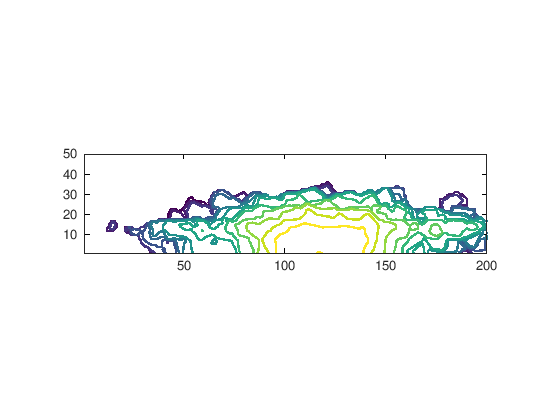

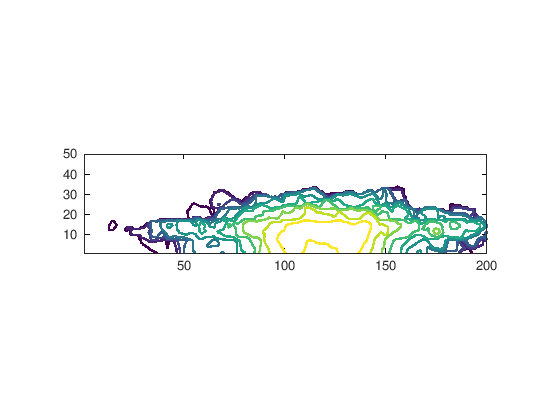

In [ ]:
%%octave

load sim_data
load layered_slab
load adjoint_sim

% distance along the x-axis for the plane containing
% source and detectors
cross_section_srcdist = 99.5;

% define a plane using cross section srcplane:
cutting_plane = [cross_section_srcdist 0 0;cross_section_srcdist 1 0;cross_section_srcdist 0 1];

% vector of y-coorinates for the cross section
% note that our slab is 200mm wide
% if we want to plot fluence values at the center of each 1mm cube,
% we would start at 0.5 and go to 199.5 with 200 steps
cubesize = 1; % cube of 1mm x 1mm x 1mm

y_vals = linspace(0+cubesize/2, 200-cubesize/2, 200);

% vector of z-coordinates for the cross section
% same as y-coordinates but the height of the slab is 50mm
z_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% make a grid of coordinates for all fluence values in the cross section
[yy,zz]=meshgrid(y_vals,z_vals);

% qmeshcut gets the intersections of all mesh edges and a plane
% as a set of coordinate points and a set of interpolated values
[cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data.*fluence_adj.data,cutting_plane);

plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
[yy_plot,zz_plot]=meshgrid(1:(200),1:(50));
figure;
clines = [-20:1:0];
contour(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),clines, 'linewidth',5,'linestyle','--','DisplayName','Diffusion');
axis equal;

%% we can also re-plot with jacobian values unbiased by node volumes:

%get node volumes
node_volumes = nodevolume(cfg_mmc.node, cfg_mmc.elem);

% qmeshcut gets the intersections of all mesh edges and a plane
% as a set of coordinate points and a set of interpolated values
[cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data.*fluence_adj.data./node_volumes,cutting_plane);

plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
[yy_plot,zz_plot]=meshgrid(1:(200),1:(50));
figure;
clines = [-20:1:0];
contour(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),clines, 'linewidth',5,'linestyle','--','DisplayName','Diffusion');
axis equal;


